In [ ]:
!pip install pmdarima

In [ ]:
!pip3 install pystan

In [ ]:
 # 日本語化ライブラリ導入
!pip install japanize-matplotlib | tail -n 1
!pip install pystan~=2.14
!pip install plotly

In [ ]:
# ライブラリーの読み込み
import numpy as np
import pandas as pd
import pmdarima as pm
from pmdarima import utils
from pmdarima import arima
from pmdarima import model_selection
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_percentage_error
from matplotlib import pyplot as plt

# グラフのスタイルとサイズ
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 6]


# matplotlib日本語化対応
import japanize_matplotlib

シミュレーション

モデルが加法の場合

In [ ]:
import math

# 時間毎のデータ
def hourly_data(start_date, end_date):
    date_range = pd.date_range(start_date, end_date, freq='H')
    data = np.zeros(len(date_range))

    for i in range(len(date_range)):
        # 日毎の周期性
        daily_cycle = math.sin(2 * math.pi * i / 24)
        # 週毎の周期性
        weekly_cycle = math.sin(2 * math.pi * i / (24*7))
        # 年毎の周期性
        yearly_cycle = math.sin(2 * math.pi * i / (24*365))
        #加法モデルの作成
        data[i] = daily_cycle + weekly_cycle + yearly_cycle
    #ノイズの追加
    noise = np.random.normal(0, 1, len(date_range))
    return pd.Series(data + noise, index=date_range)

# データの期間
hourly = hourly_data('2021-01-01', '2023-12-31')


# 時間の列と値の列を分ける
df = hourly.reset_index()
df.columns = ['Time', 'Value']

print("Hourly data with daily, weekly, and yearly periodicity:\n", df)


Hourly data with daily, weekly, and yearly periodicity:
                      Time     Value
0     2021-01-01 00:00:00  0.265823
1     2021-01-01 01:00:00 -0.076420
2     2021-01-01 02:00:00  2.170581
3     2021-01-01 03:00:00  1.256718
4     2021-01-01 04:00:00  0.327426
...                   ...       ...
26252 2023-12-30 20:00:00  1.325742
26253 2023-12-30 21:00:00  1.280135
26254 2023-12-30 22:00:00 -1.458934
26255 2023-12-30 23:00:00  0.266088
26256 2023-12-31 00:00:00  1.162055

[26257 rows x 2 columns]


In [ ]:
#データの前処理
date_time = df["Time"]
data = df["Value"]
data = data.values
print(type(data))

<class 'numpy.ndarray'>


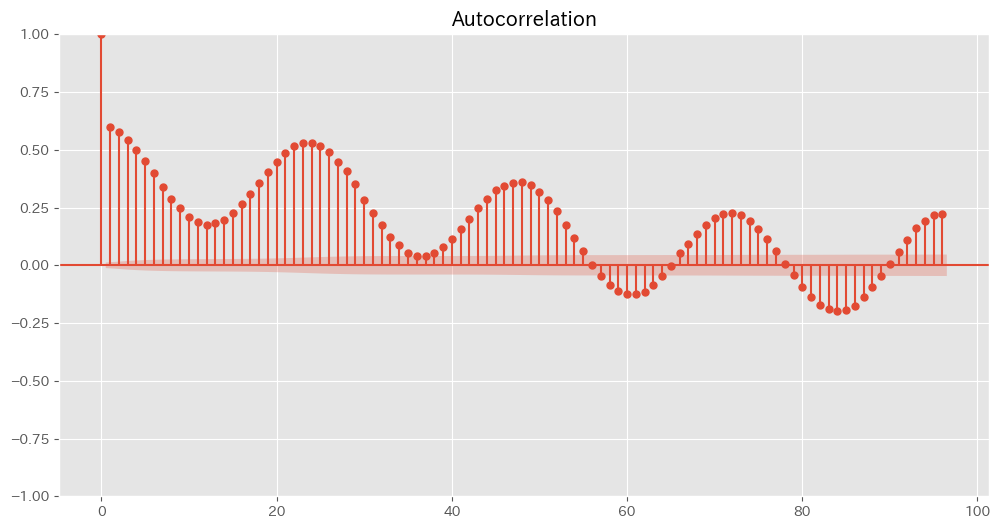

In [ ]:
#自己相関のグラフ
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
plt.rc("figure", figsize = (12, 6))
grap = sm.graphics.tsa.plot_acf(data, lags =96)

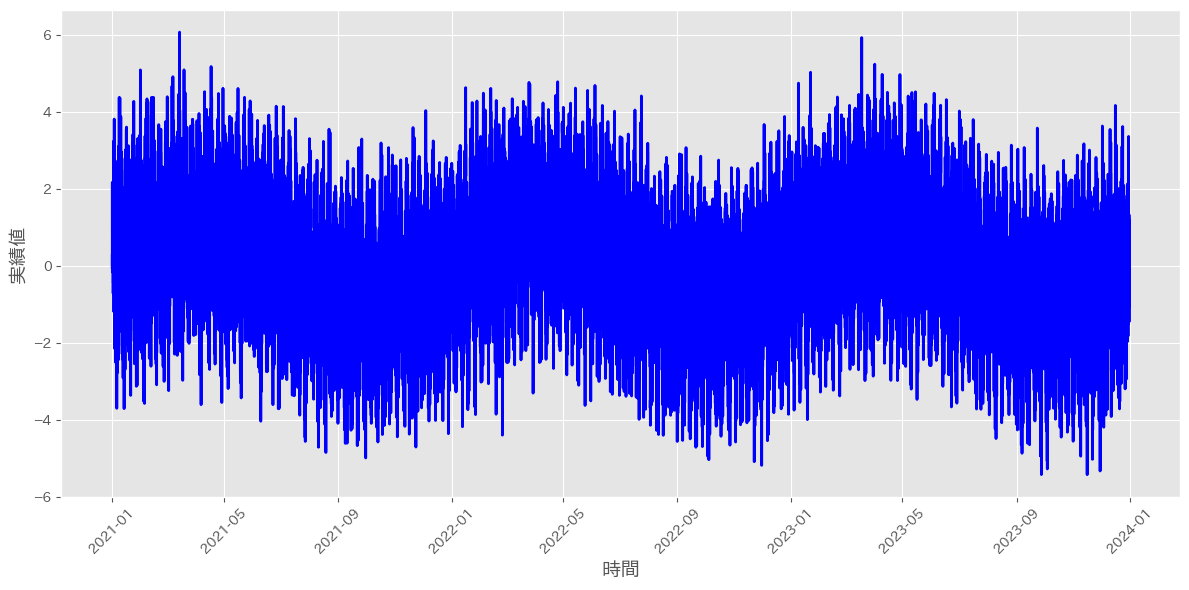

In [ ]:
# 折れ線グラフを描画
plt.plot(date_time, data, color='b', linestyle='-', linewidth=2, markersize=8)
#plt.xticks(np.arange(0, 26310, step=24))
plt.xlabel('時間', fontsize=14)
plt.ylabel('実績値', fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()


# グラフを表示
plt.show()

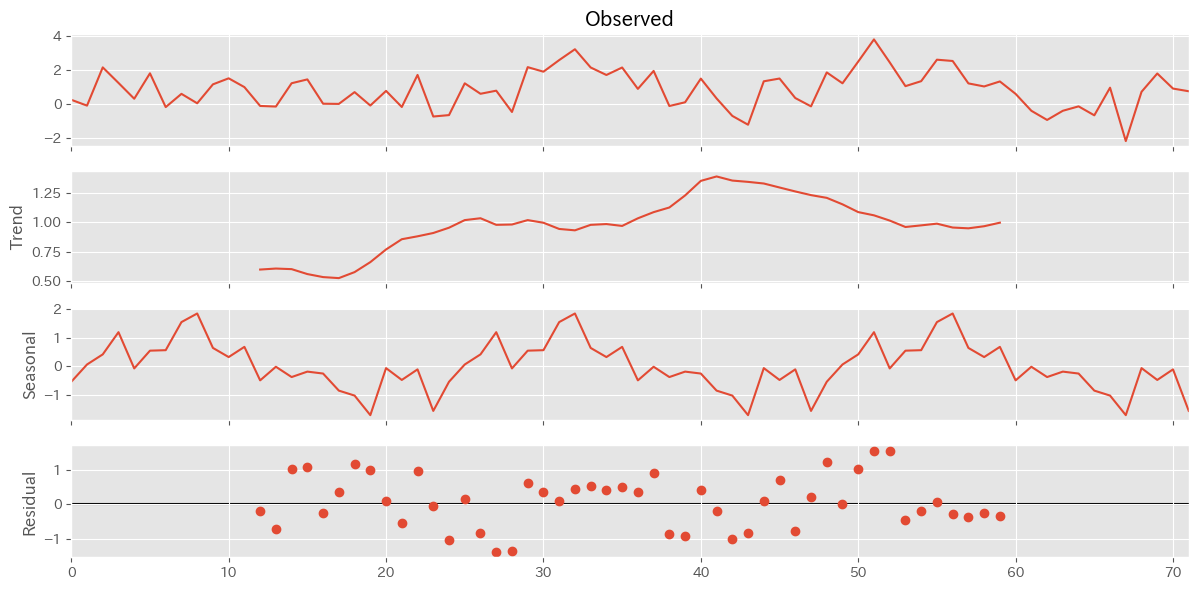

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
# 成分分解を実行
result = seasonal_decompose(data[:72], model='additive', period=24)

# 結果のプロット
result.plot()
plt.show()

In [ ]:
# 1次の階差を取得
#data_diff = np.diff(data, n=1)
data_diff = data
print(len(data_diff))
print(data[:26])
print(data_diff[:14])

26257
[ 0.26582319 -0.07641976  2.17058099  1.2567183   0.32742608  1.82206972
 -0.16376319  0.61487614  0.06057522  1.17314943  1.52798938  1.01123291
 -0.09602457 -0.13062136  1.23964802  1.4643098   0.03562741  0.02483914
  0.71693459 -0.07116765  0.78842193 -0.15659763  1.72635434 -0.71682733
 -0.63362309  1.23378573]
[ 0.26582319 -0.07641976  2.17058099  1.2567183   0.32742608  1.82206972
 -0.16376319  0.61487614  0.06057522  1.17314943  1.52798938  1.01123291
 -0.09602457 -0.13062136]


<Figure size 1200x600 with 0 Axes>

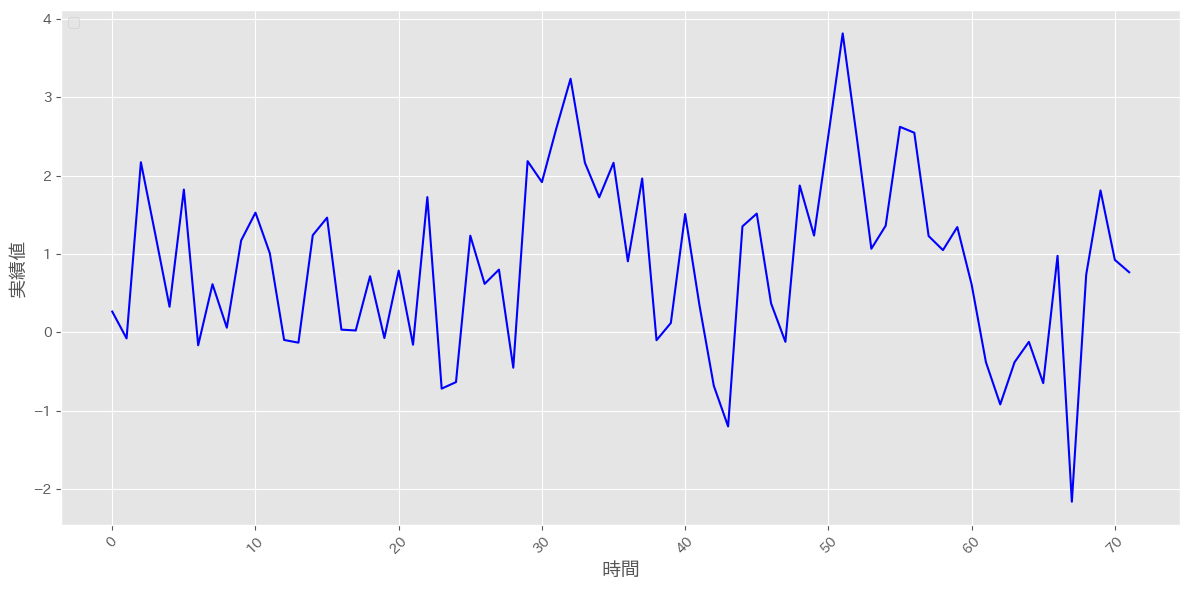

In [ ]:
# 移動平均の計算（例として5期間の移動平均を計算）
#df = pd.DataFrame(train_diff)
#rolling_average = df.rolling(window=24).mean()

# グラフの描画
plt.figure(figsize=(12, 6))
fig, ax = plt.subplots()

# 折れ線グラフ
plt.plot(data_diff[:72], color='blue')

# 移動平均のグラフ
#plt.plot(rolling_average[:72], label='24時間の移動平均', color='red')

# グラフにタイトルと軸ラベルを追加
plt.xlabel('時間', fontsize=14)
plt.ylabel('実績値', fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
ax.legend(loc='upper left')
plt.show()


[ 0.26582319 -0.07641976  2.17058099  1.2567183   0.32742608  1.82206972
 -0.16376319  0.61487614  0.06057522  1.17314943  1.52798938  1.01123291
 -0.09602457 -0.13062136  1.23964802  1.4643098   0.03562741  0.02483914
  0.71693459 -0.07116765  0.78842193 -0.15659763  1.72635434 -0.71682733
 -0.63362309  1.23378573  0.61937149  0.80120747 -0.44985563  2.18451286]
[-0.89944628  1.31020548 -1.5512095  -0.45551083 -0.77728171]


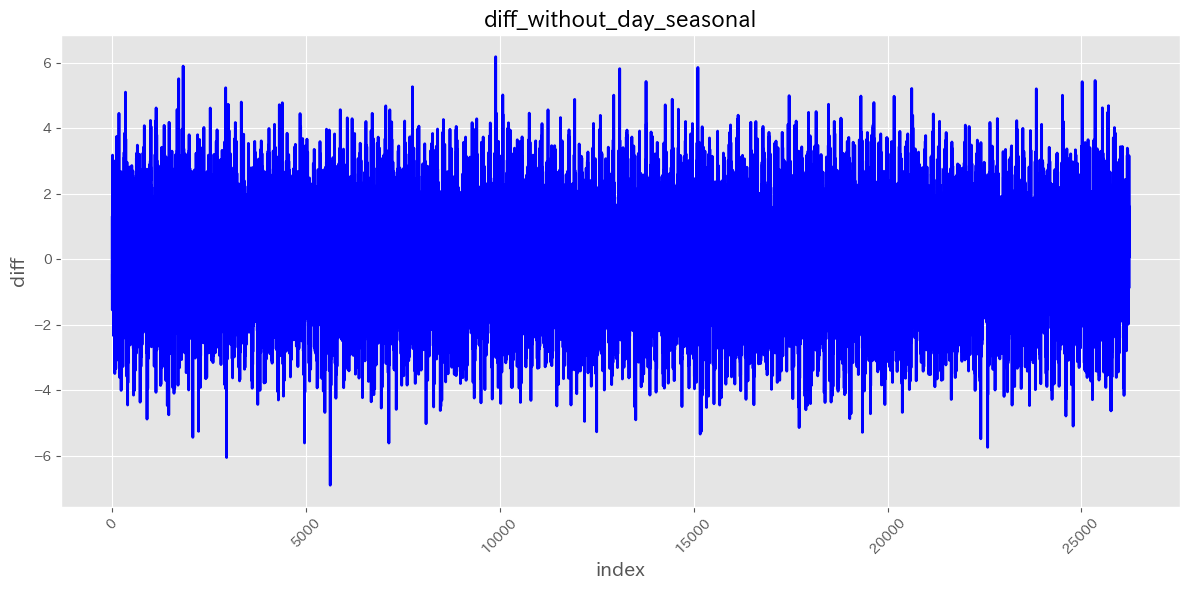

In [ ]:
#24時間季節性を抜く
print(data_diff[:30])
diff_without_day_seasonal = data_diff[24:] - data_diff[:-24]
print(diff_without_day_seasonal[:5])

#plt.figure(figsize=(12, 6))
plt.plot(range(len(diff_without_day_seasonal)), diff_without_day_seasonal, color='b', linestyle='-', linewidth=2, markersize=8)
plt.title('diff_without_day_seasonal', fontsize=16)
plt.xlabel('index', fontsize=14)
plt.ylabel('diff', fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()


# グラフを表示
plt.show()

45


/usr/local/lib/python3.10/dist-packages/pmdarima/utils/visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


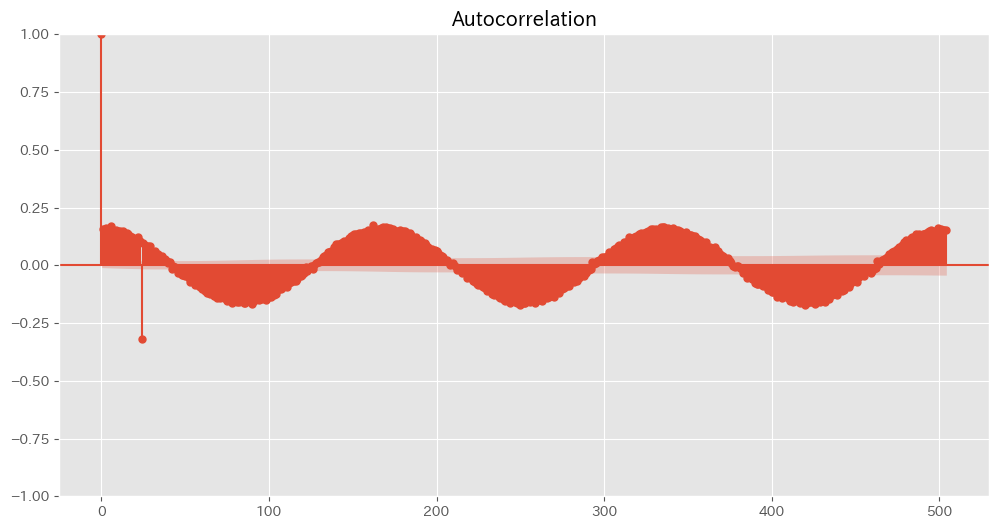

In [ ]:
# 24時間の季節性を抜いた後のコレログラム（自己相関と偏自己相関）
import statsmodels.tsa.stattools as tsat
day_autocorrelation = tsat.acf(diff_without_day_seasonal)
print(len(day_autocorrelation))
plt.rc("figure", figsize = (12, 6))
utils.plot_acf(diff_without_day_seasonal, alpha=.05, lags=168*3)

[-8.99446275e-01  1.31020548e+00 -1.55120950e+00 -4.55510829e-01
 -7.77281712e-01  3.62443139e-01  2.08097589e+00  1.98408425e+00
  3.17536754e+00  9.91638641e-01  1.95832989e-01  1.15260154e+00
  1.00334301e+00  2.09385082e+00 -1.33902288e+00 -1.34424643e+00
  1.47457338e+00  3.20928026e-01 -1.39704502e+00 -1.12823456e+00
  5.64367428e-01  1.67230183e+00 -1.35638877e+00  5.96863733e-01
  2.50795494e+00  1.96775343e-03  1.89372426e+00  3.01288793e+00
  2.91656554e+00 -1.11674907e+00]


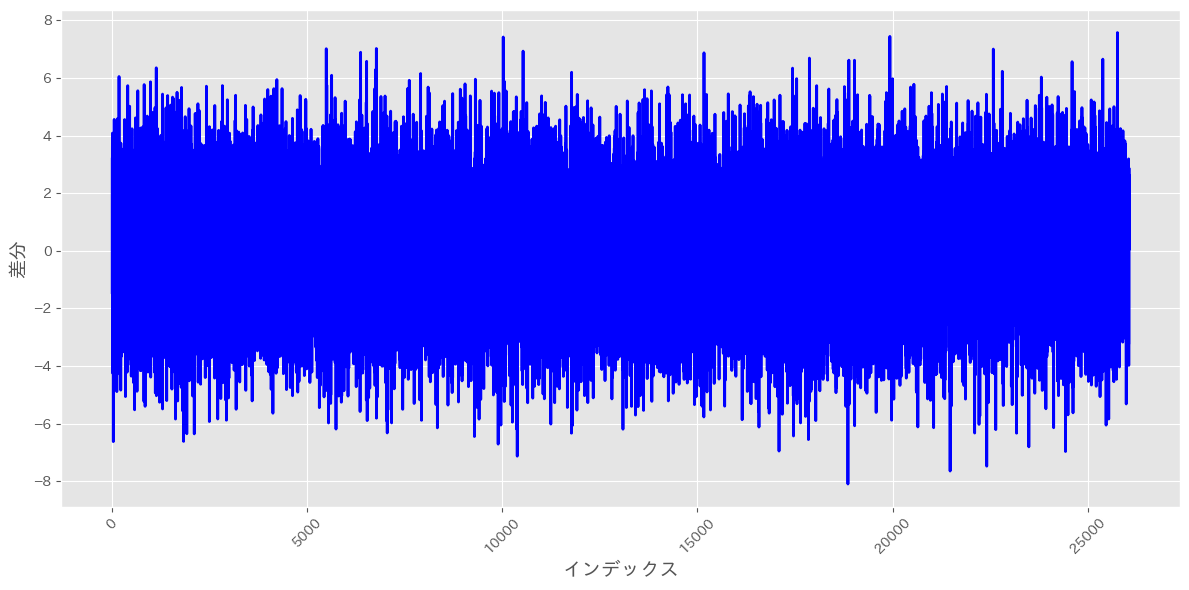

In [ ]:
#24時間季節性を抜く
print(diff_without_day_seasonal[:30])
diff_without_week_seasonal = diff_without_day_seasonal[168:] - diff_without_day_seasonal[:-168]


#plt.figure(figsize=(12, 6))
plt.plot(range(len(diff_without_week_seasonal)), diff_without_week_seasonal, color='b', linestyle='-', linewidth=2, markersize=8)
plt.xlabel('インデックス', fontsize=14)
plt.ylabel('差分', fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()


# グラフを表示
plt.show()

17521
1.0
0.0006241047990816435
0.0030130688100327473


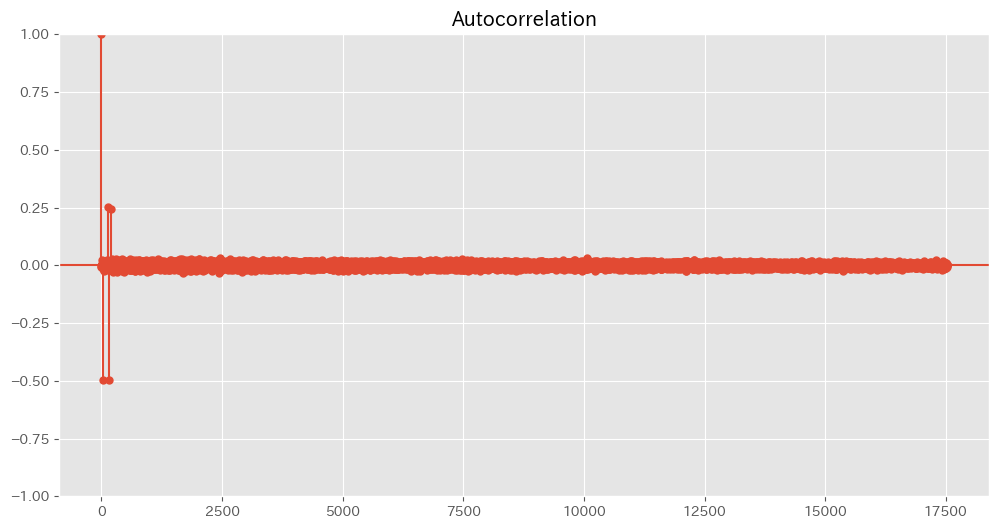

In [ ]:
# １週間の季節性を抜いた後のコレログラム（自己相関と偏自己相関）
from statsmodels.tsa.stattools import acf
week_autocorrelation = acf(diff_without_week_seasonal, fft=False, nlags=24*365*2)
print(len(week_autocorrelation))
print(week_autocorrelation[0])
print(week_autocorrelation[24*365])
print(week_autocorrelation[24*365*2])
plt.rc("figure", figsize = (12, 6))
utils.plot_acf(diff_without_week_seasonal, alpha=.05, lags=24*365*2)

[ 3.18445618 -1.49706181  0.8415186   3.56422702 -1.67060625  4.08737258
 -3.03601193 -1.60248699 -0.74371957 -1.75467882 -1.27618253 -4.25014349
 -0.97824597 -1.83794075  4.00395013  1.11403522  0.05722761 -2.03519334
  1.90882813  0.7527634  -1.94413472 -1.96707413  1.88080109  1.07505561
 -4.00802131  0.43403569 -2.147399   -6.62951855 -1.53783947  0.62869848]
[-1.11548754  0.740971   -1.36786204 -2.70399974  1.6159612 ]


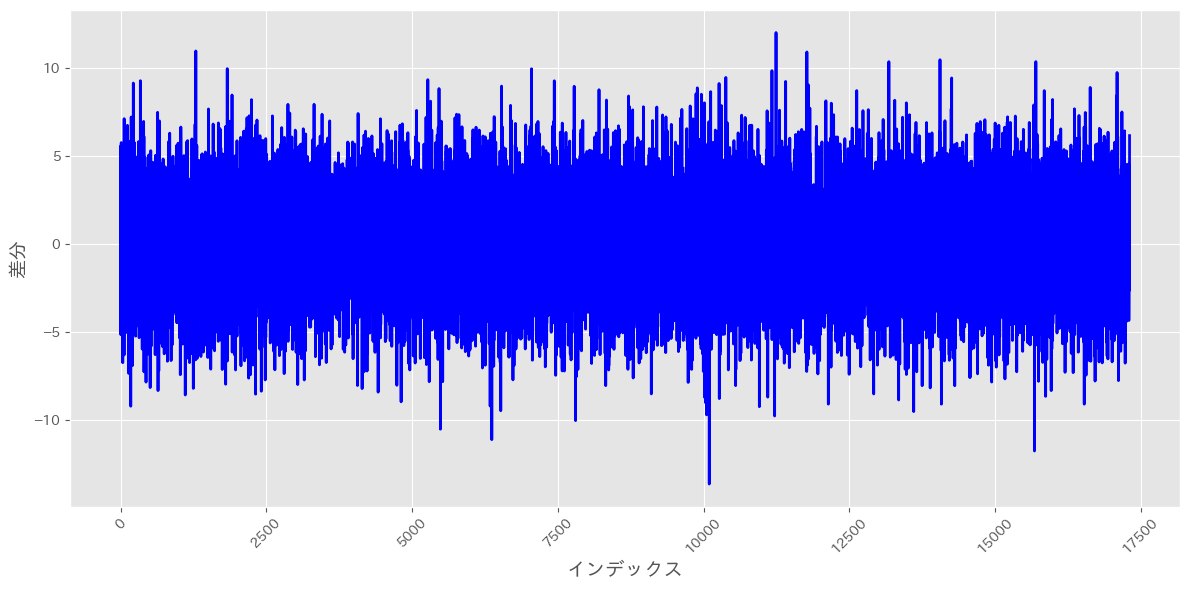

In [ ]:
#年間の季節性を抜く
print(diff_without_week_seasonal[:30])
diff_without_year_seasonal = diff_without_week_seasonal[8760:] - diff_without_week_seasonal[:-8760]
print(diff_without_year_seasonal[:5])

#plt.figure(figsize=(12, 6))
plt.plot(range(len(diff_without_year_seasonal)), diff_without_year_seasonal, color='b', linestyle='-', linewidth=2, markersize=8)
#plt.title('diff_without_year_seasonal', fontsize=16)
plt.xlabel('インデックス', fontsize=14)
plt.ylabel('差分', fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()


# グラフを表示
plt.show()

[ 1.00000000e+00 -1.46740506e-02  6.13462020e-04 -4.61094441e-03
 -1.22895395e-02 -2.80730412e-03 -5.40305463e-04 -1.64207243e-02
 -1.14526245e-03 -1.37114556e-02  8.31962165e-03 -9.61915582e-03
  6.70270380e-03  8.92489878e-03 -1.16513825e-02  1.72552714e-02
  2.71718005e-03  4.31650202e-03  1.06252574e-02  1.24352543e-02
  5.18982774e-03 -7.97215595e-03  1.23689396e-02  1.27676464e-02
 -4.95956093e-01  1.29407131e-02 -1.02556469e-02 -1.68859619e-03
  1.93377931e-02  3.16735801e-03 -2.92535599e-03  7.87646607e-03
 -3.12057946e-03  2.70157520e-03 -6.51170141e-03  2.60765267e-05
 -8.46392811e-03 -3.17112560e-03  1.98756855e-02  6.67025483e-03
  1.32498455e-03 -2.06937905e-03 -1.49587005e-02]


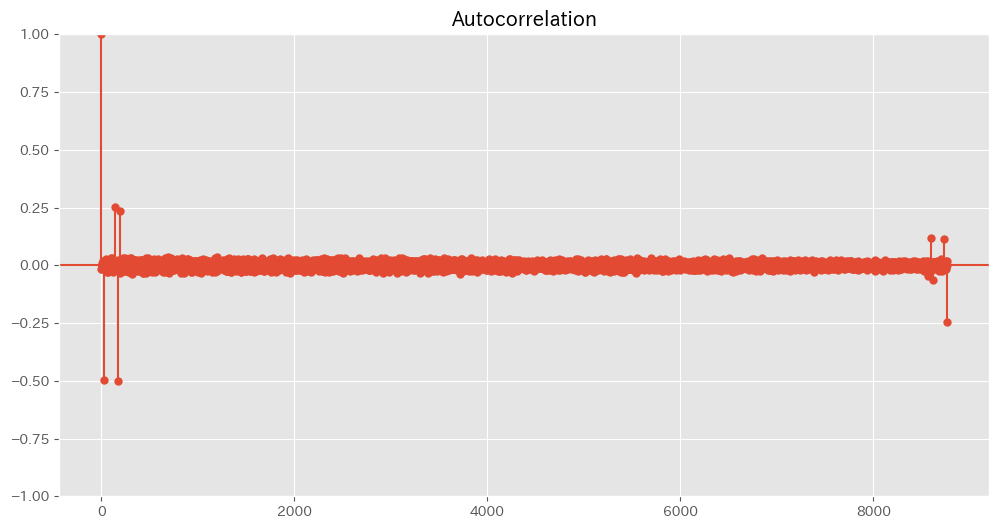

In [ ]:
# 年毎の季節成分を抜いた後のコレログラム（自己相関と偏自己相関）
autocorrelation = acf(diff_without_year_seasonal, fft=False)
print(autocorrelation)
plt.rc("figure", figsize = (12, 6))
utils.plot_acf(diff_without_year_seasonal, alpha=.05, lags=24*365)

乗法のモデル

In [ ]:
import math

# 時間毎のデータ
def hourly_data(start_date, end_date):
    date_range = pd.date_range(start_date, end_date, freq='H')
    data = np.zeros(len(date_range))

    for i in range(len(date_range)):
        # 日毎の周期性
        daily_cycle = math.sin(2 * math.pi * i / 24) + 2
        # 週毎の周期性
        weekly_cycle = math.sin(2 * math.pi * i / (24*7)) + 2
        # 年毎の周期性
        yearly_cycle = math.sin(2 * math.pi * i / (24*365)) + 2

        data[i] = daily_cycle * weekly_cycle * yearly_cycle

    noise = np.random.normal(0, 1, len(date_range))
    return pd.Series(data * noise, index=date_range)

# データの生成
hourly = hourly_data('2021-01-01', '2023-12-31')


# 時間の列と値の列を分ける
df = hourly.reset_index()
df.columns = ['Time', 'Value']

print("Hourly data with daily, weekly, and yearly periodicity:\n", df)


Hourly data with daily, weekly, and yearly periodicity:
                      Time      Value
0     2021-01-01 00:00:00  -6.831988
1     2021-01-01 01:00:00   4.559020
2     2021-01-01 02:00:00   6.327325
3     2021-01-01 03:00:00  23.148008
4     2021-01-01 04:00:00 -11.949196
...                   ...        ...
26252 2023-12-30 20:00:00   5.079657
26253 2023-12-30 21:00:00   8.940433
26254 2023-12-30 22:00:00   8.348275
26255 2023-12-30 23:00:00 -16.475623
26256 2023-12-31 00:00:00  10.842675

[26257 rows x 2 columns]


In [ ]:
#データの前処理
date_times = df["Time"]
datas = df["Value"]

datas = datas.values


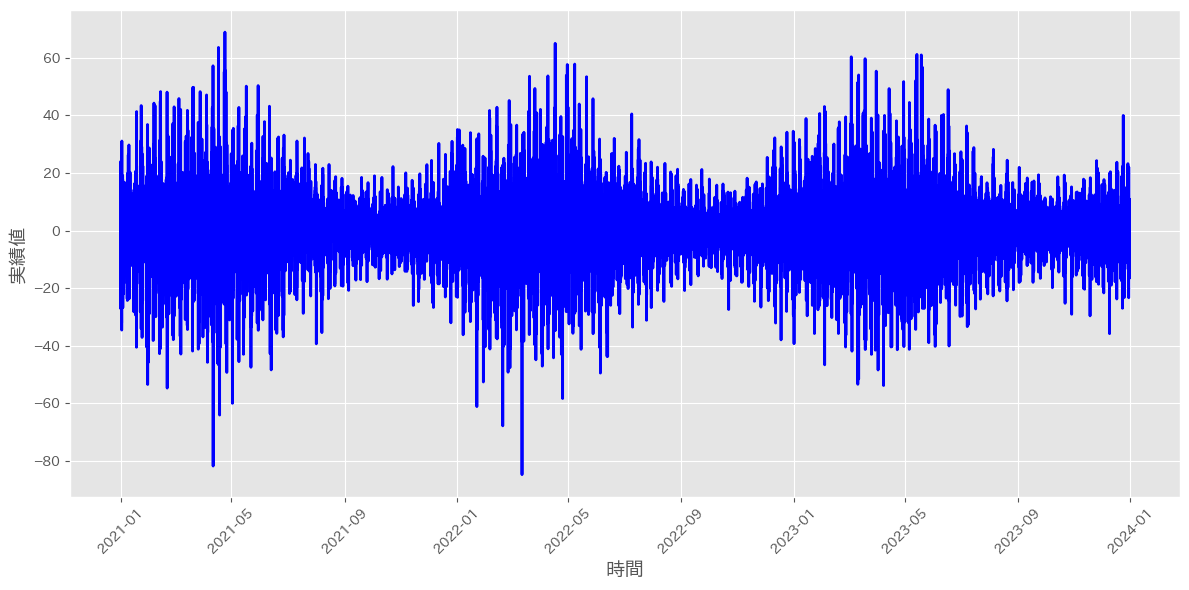

In [ ]:
# 原系列データの折れ線グラフを描画
plt.plot(date_times, datas, color='b', linestyle='-', linewidth=2, markersize=8)
#plt.xticks(np.arange(0, 26310, step=24))
plt.xlabel('時間', fontsize=14)
plt.ylabel('実績値', fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()


# グラフを表示
plt.show()

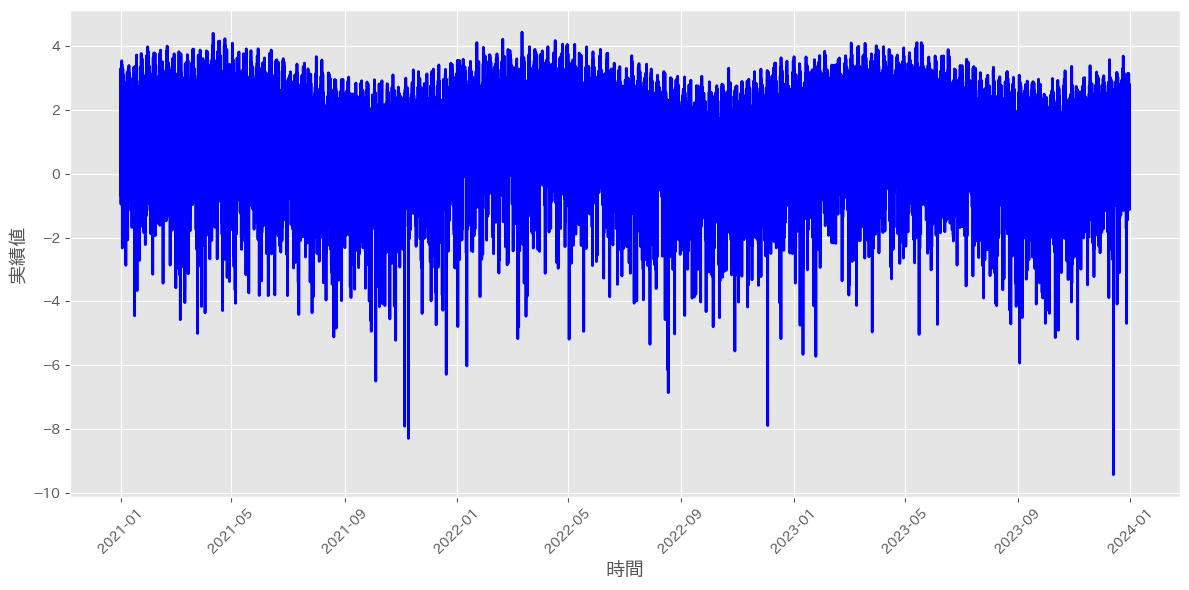

In [ ]:
#対数系列データの折れ線グラフを描画
datas = np.abs(datas)
datas = np.log(datas)

plt.plot(date_times, datas, color='b', linestyle='-', linewidth=2, markersize=8)
#plt.xticks(np.arange(0, 26310, step=24))
plt.xlabel('時間', fontsize=14)
plt.ylabel('実績値', fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()


# グラフを表示
plt.show()

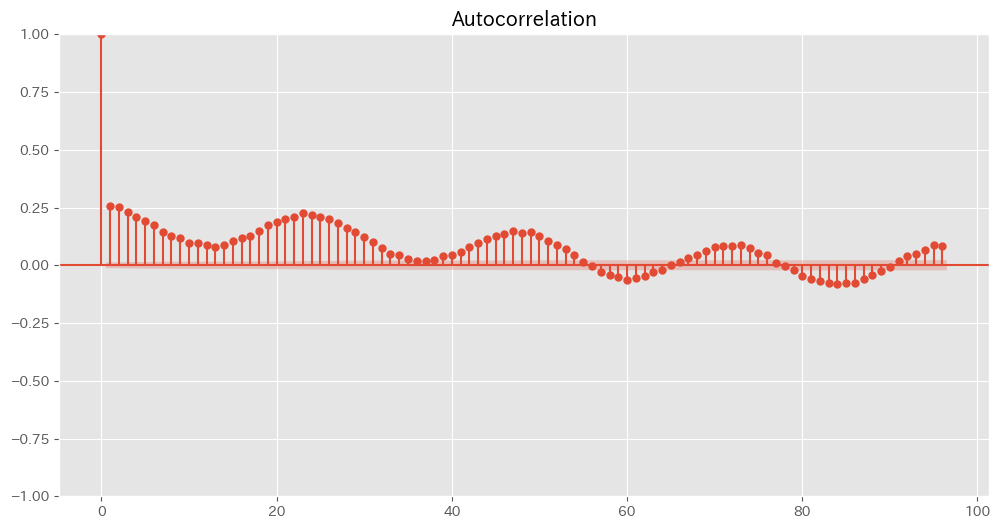

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
plt.rc("figure", figsize = (12, 6))
grap = sm.graphics.tsa.plot_acf(datas, lags =96)

[ 0.26582319 -0.07641976  2.17058099  1.2567183   0.32742608  1.82206972
 -0.16376319  0.61487614  0.06057522  1.17314943  1.52798938  1.01123291
 -0.09602457 -0.13062136  1.23964802  1.4643098   0.03562741  0.02483914
  0.71693459 -0.07116765  0.78842193 -0.15659763  1.72635434 -0.71682733
 -0.63362309  1.23378573  0.61937149  0.80120747 -0.44985563  2.18451286]
[-0.89944628  1.31020548 -1.5512095  -0.45551083 -0.77728171]


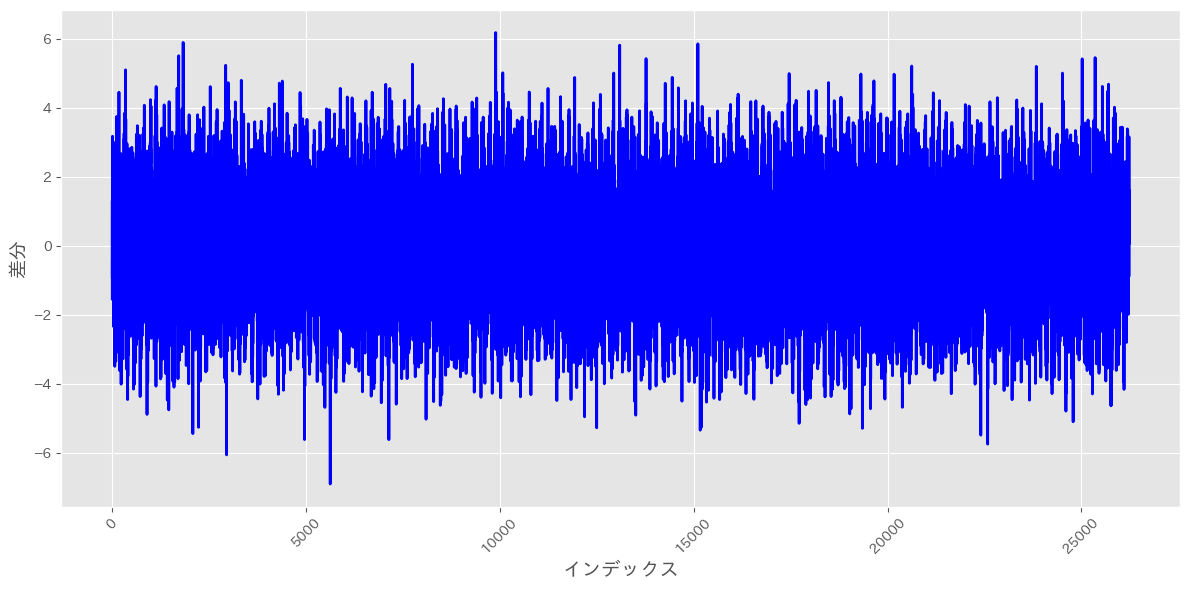

In [ ]:
#24時間季節性を抜く
print(data_diff[:30])
diff_without_day_seasonal = data_diff[24:] - data_diff[:-24]
print(diff_without_day_seasonal[:5])

#plt.figure(figsize=(12, 6))
plt.plot(range(len(diff_without_day_seasonal)), diff_without_day_seasonal, color='b', linestyle='-', linewidth=2, markersize=8)
#plt.title('diff_without_day_seasonal', fontsize=16)
plt.xlabel('インデックス', fontsize=14)
plt.ylabel('差分', fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()


# グラフを表示
plt.show()

45


/usr/local/lib/python3.10/dist-packages/pmdarima/utils/visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


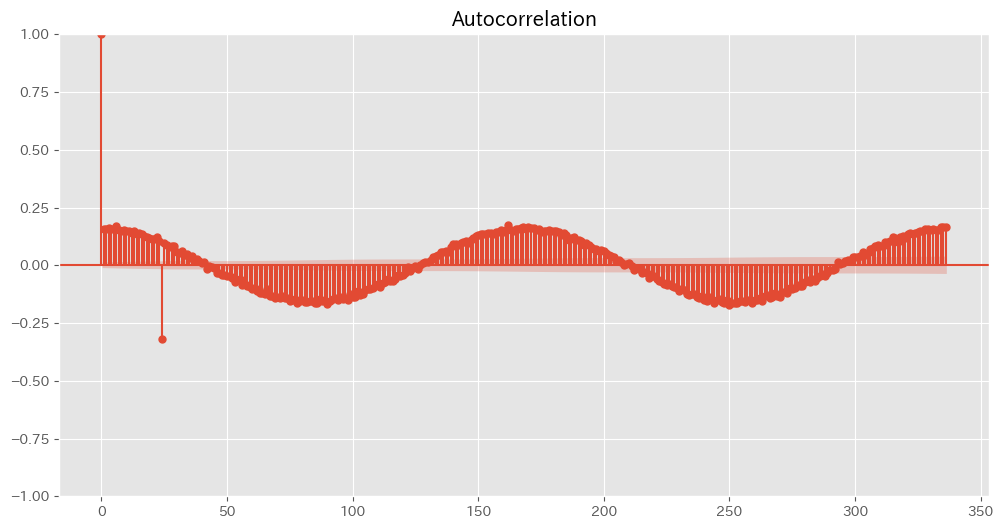

In [ ]:
# 日毎の季節成分を抜いた後のコレログラム（自己相関と偏自己相関）
import statsmodels.tsa.stattools as tsat
day_autocorrelation = tsat.acf(diff_without_day_seasonal)
print(len(day_autocorrelation))
plt.rc("figure", figsize = (12, 6))
utils.plot_acf(diff_without_day_seasonal, alpha=.05, lags=336)

[-8.99446275e-01  1.31020548e+00 -1.55120950e+00 -4.55510829e-01
 -7.77281712e-01  3.62443139e-01  2.08097589e+00  1.98408425e+00
  3.17536754e+00  9.91638641e-01  1.95832989e-01  1.15260154e+00
  1.00334301e+00  2.09385082e+00 -1.33902288e+00 -1.34424643e+00
  1.47457338e+00  3.20928026e-01 -1.39704502e+00 -1.12823456e+00
  5.64367428e-01  1.67230183e+00 -1.35638877e+00  5.96863733e-01
  2.50795494e+00  1.96775343e-03  1.89372426e+00  3.01288793e+00
  2.91656554e+00 -1.11674907e+00]


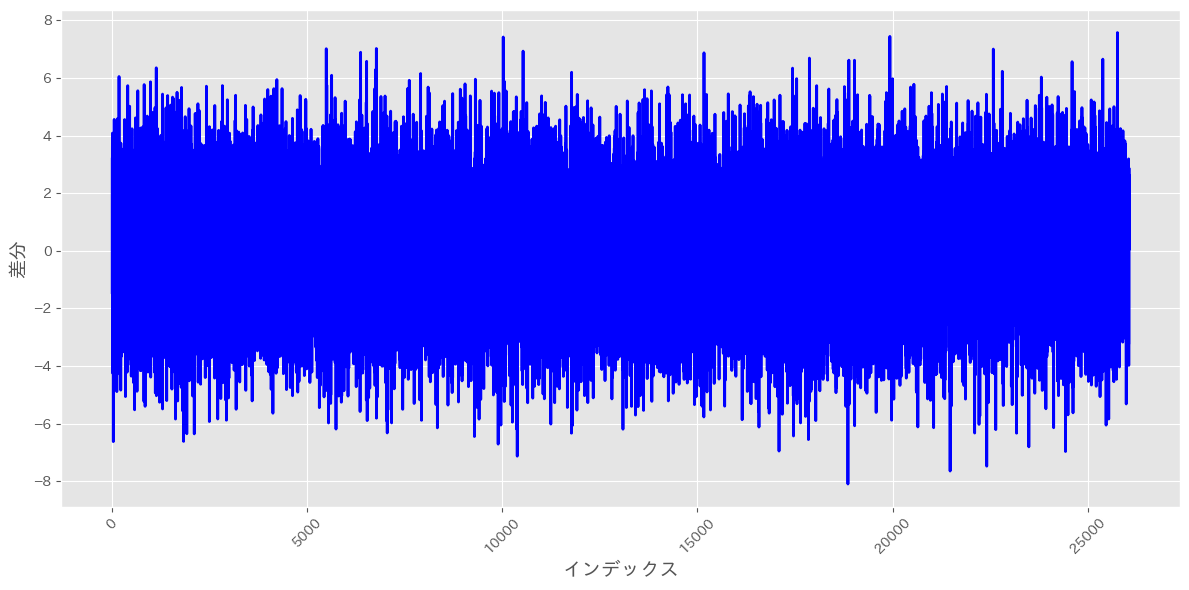

In [ ]:
#週毎の季節成分を抜く
print(diff_without_day_seasonal[:30])
diff_without_week_seasonal = diff_without_day_seasonal[168:] - diff_without_day_seasonal[:-168]


#plt.figure(figsize=(12, 6))
plt.plot(range(len(diff_without_week_seasonal)), diff_without_week_seasonal, color='b', linestyle='-', linewidth=2, markersize=8)
#plt.title('diff_without_week_seasonal', fontsize=16)
plt.xlabel('インデックス', fontsize=14)
plt.ylabel('差分', fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()


# グラフを表示
plt.show()

17521
1.0
0.0006241047990816435
0.0030130688100327473


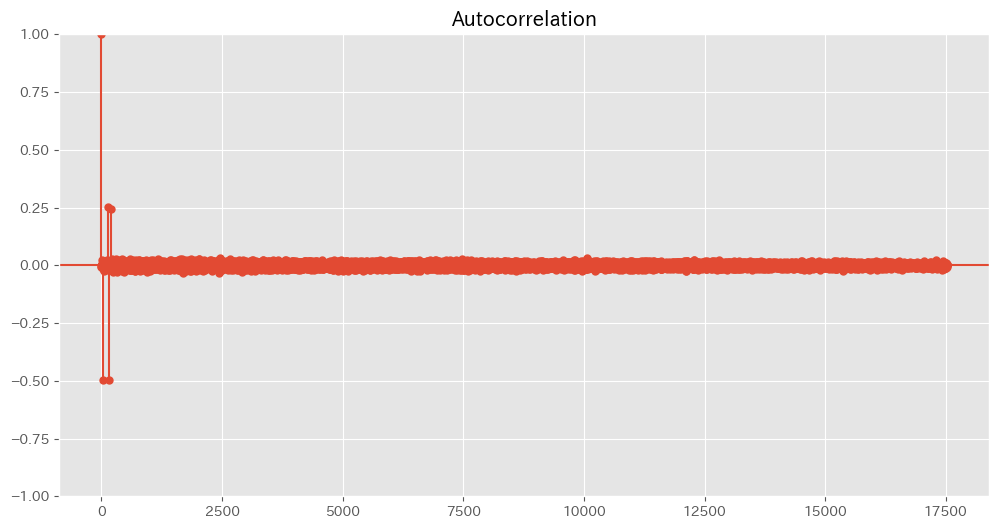

In [ ]:
# 週毎の季節性を抜いた後のコレログラム（自己相関と偏自己相関）
from statsmodels.tsa.stattools import acf
week_autocorrelation = acf(diff_without_week_seasonal, fft=False, nlags=24*365*2)
print(len(week_autocorrelation))
print(week_autocorrelation[0])
print(week_autocorrelation[24*365])
print(week_autocorrelation[24*365*2])
plt.rc("figure", figsize = (12, 6))
utils.plot_acf(diff_without_week_seasonal, alpha=.05, lags=24*365*2)

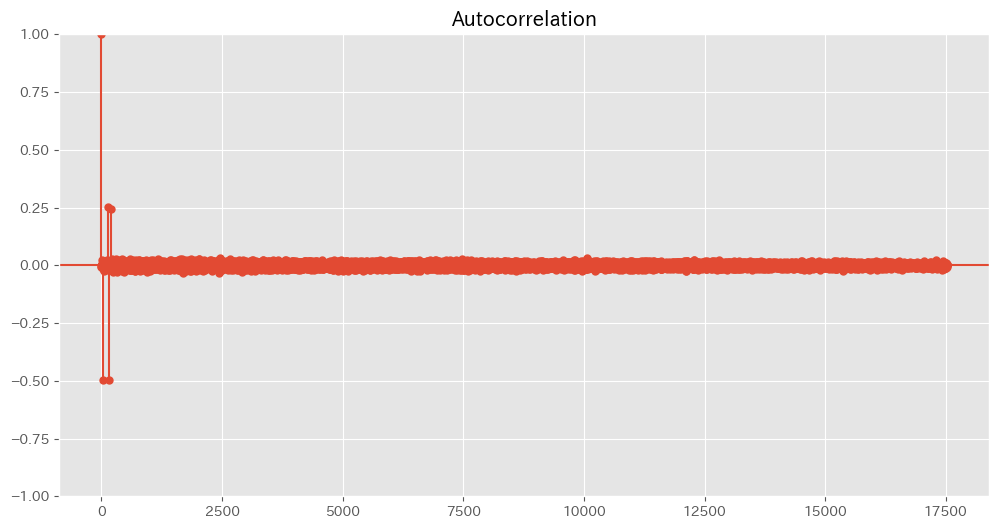

In [ ]:
utils.plot_acf(diff_without_week_seasonal, alpha=.05, lags=24*365*2)

電力のデータのシミュレーション

In [ ]:

years = [2021, 2022, 2023]
df = pd.DataFrame()
for year in years:
    _df = pd.read_csv(f"https://www.tepco.co.jp/forecast/html/images/juyo-{year}.csv", encoding="shift-jis", skiprows=1)
    df = pd.concat([df, _df], axis=0)


In [ ]:
df["実績(万kW)"]

0       3184
1       2978
2       2834
3       2743
4       2697
        ... 
8755    2919
8756    2845
8757    2754
8758    2647
8759    2583
Name: 実績(万kW), Length: 26280, dtype: int64

In [ ]:
#データの前処理
df = df.reset_index(drop=True)
date = df["DATE"][0]
time = df["TIME"][0]
str_datetime = f"{date} {time}"
str_datetime
from datetime import datetime as dt
datetime = dt.strptime(str_datetime, "%Y/%m/%d %H:%M")

datatimes = []
for index, datum in df.iterrows():
    date = datum["DATE"]
    time = datum["TIME"]
    str_datetime = f"{date} {time}"
    datatime = dt.strptime(str_datetime, "%Y/%m/%d %H:%M")
    datatimes.append(datatime)

df["ds"] = datatimes



In [ ]:
df.head()

,DATE,TIME,実績(万kW),ds
0,2021/1/1,0:00,3184,2021-01-01 00:00:00
1,2021/1/1,1:00,2978,2021-01-01 01:00:00
2,2021/1/1,2:00,2834,2021-01-01 02:00:00
3,2021/1/1,3:00,2743,2021-01-01 03:00:00
4,2021/1/1,4:00,2697,2021-01-01 04:00:00


In [ ]:
date_time = df["ds"]
print(date_time)
print(len(date_time))
data = df["実績(万kW)"]
data = data.values
print(data)
print(type(data))


0       2021-01-01 00:00:00
1       2021-01-01 01:00:00
2       2021-01-01 02:00:00
3       2021-01-01 03:00:00
4       2021-01-01 04:00:00
                ...        
26275   2023-12-31 19:00:00
26276   2023-12-31 20:00:00
26277   2023-12-31 21:00:00
26278   2023-12-31 22:00:00
26279   2023-12-31 23:00:00
Name: ds, Length: 26280, dtype: datetime64[ns]
26280
[3184 2978 2834 ... 2754 2647 2583]
<class 'numpy.ndarray'>


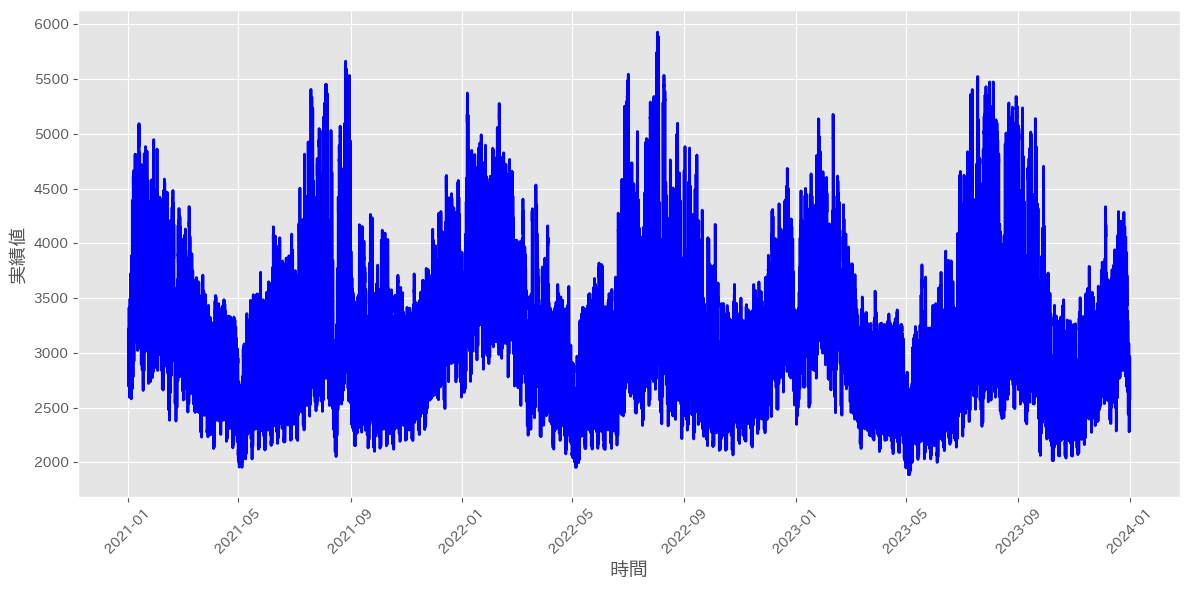

In [ ]:
# 折れ線グラフを描画

plt.plot(date_time, data, color='b', linestyle='-', linewidth=2, markersize=8)
#plt.xticks(np.arange(0, 26310, step=24))
plt.xlabel('時間', fontsize=14)
plt.ylabel('実績値', fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()


# グラフを表示
plt.show()

In [ ]:
# データの分割
train_size = int(len(data) * 0.8)  # 80%を学習データにする例
print(train_size)
train, test = data[:train_size], data[train_size:]
print(type(train))


21024
<class 'numpy.ndarray'>


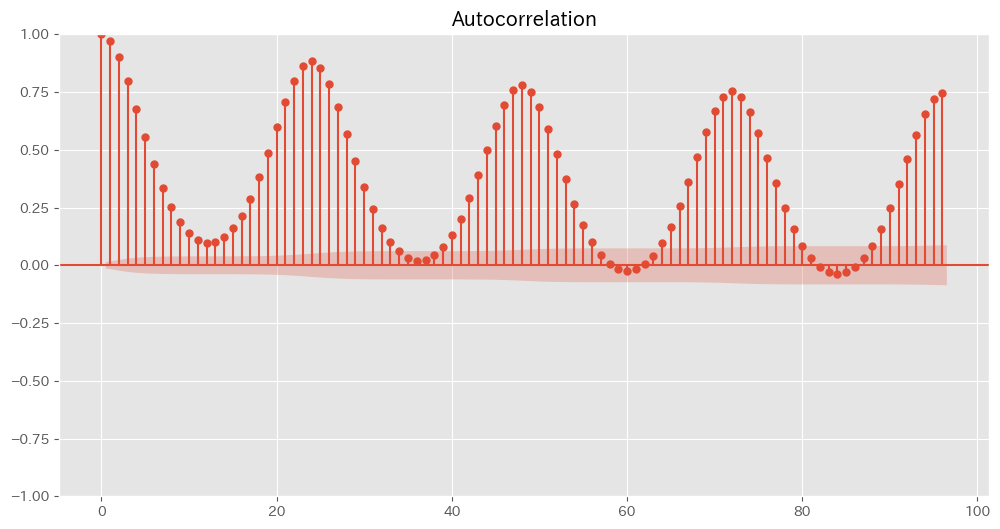

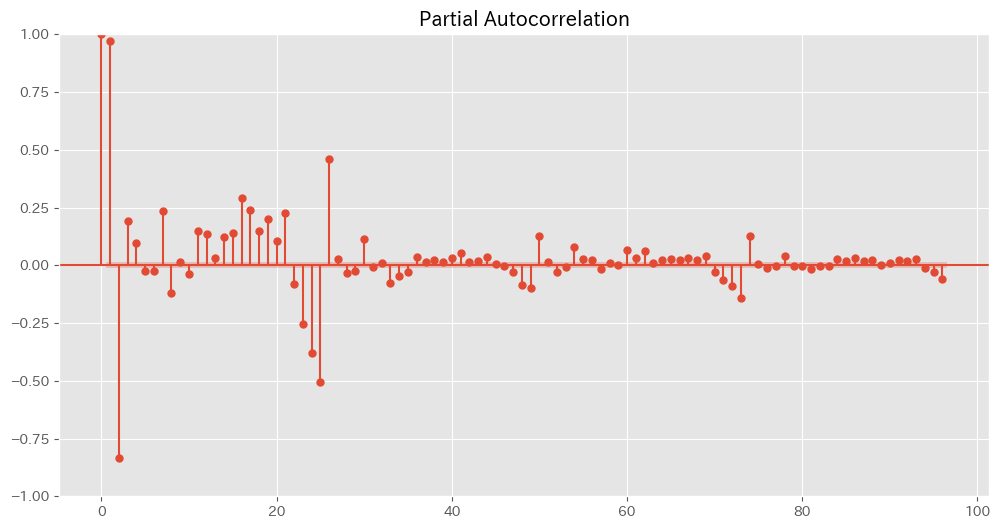

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

#相関係数で周期性を確認
plt.rc("figure", figsize = (12, 6))
grap = sm.graphics.tsa.plot_acf(train, lags =96)
utils.plot_pacf(train, alpha=.05, lags=96)

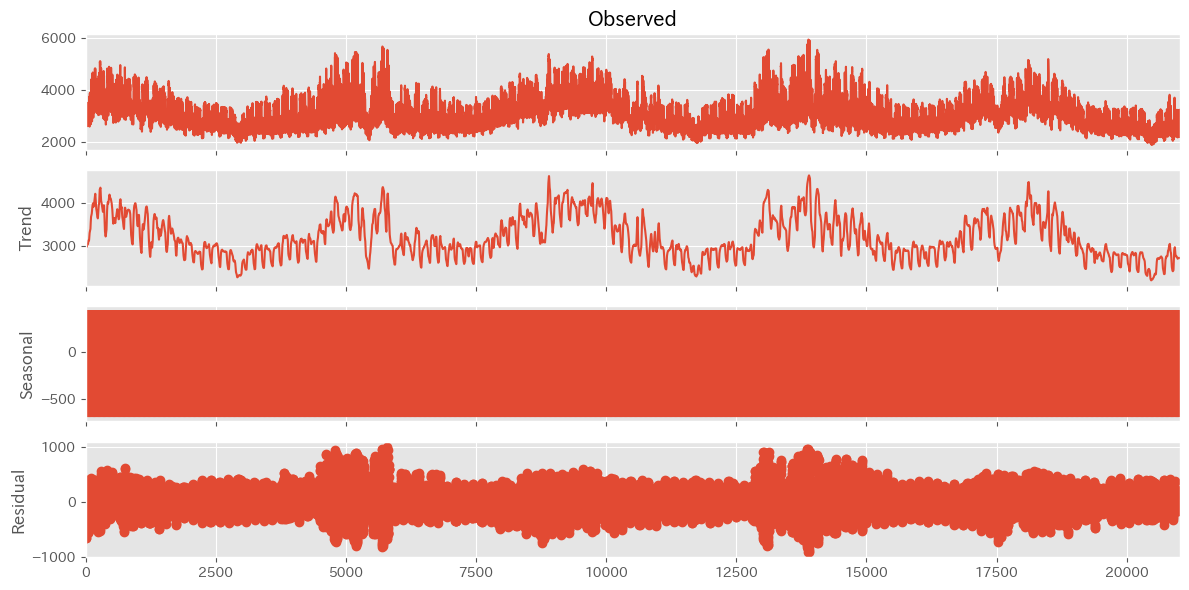

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
#短期間の成分分解を行う
# 成分分解を実行
result = seasonal_decompose(train, model='additive', period=24)

# 結果のプロット
result.plot()
plt.show()

In [ ]:
#データ変換（logにする）
train_log = np.log(train)



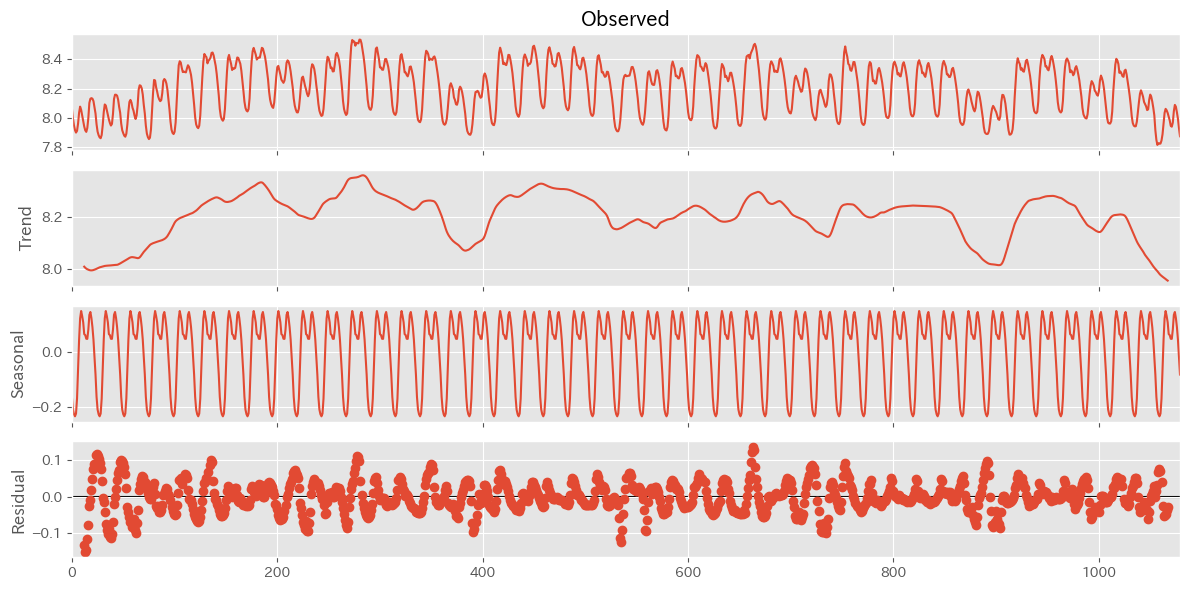

In [ ]:
#短期間の成分分解を行う
# 成分分解を実行
result = seasonal_decompose(train_log[:45*24], model='additive', period=24)

# 結果のプロット
result.plot()
plt.show()

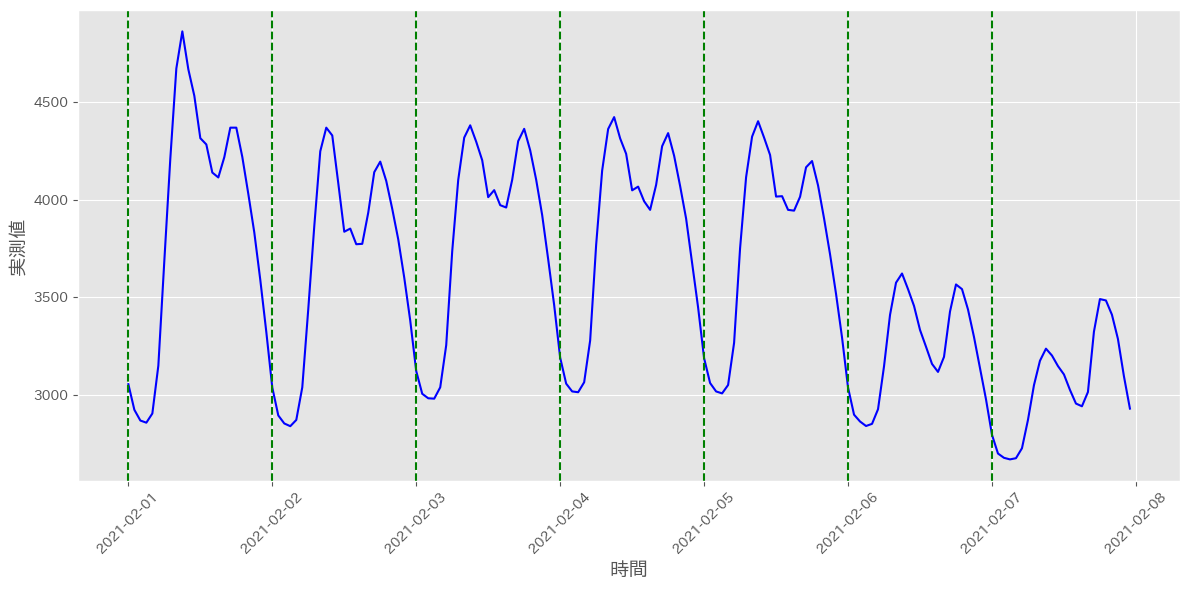

In [ ]:
plt.figure(figsize=(12, 6))

# 時間毎のデータの作成
dates = pd.date_range(start='2021-02-01', periods=7*24, freq='H')
data_ex = train[24*31:24*7+24*31]
plt.plot(dates, data_ex, color='blue')

# 日毎に線を描画
for x in np.arange(0, len(dates), 24):
    plt.axvline(x=dates[x], color='green', linestyle='--')

plt.xlabel('時間', fontsize=14)
plt.ylabel('実測値', fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()


[-0.10906642 -0.09245998 -0.0671295  -0.04970199 -0.03855353]


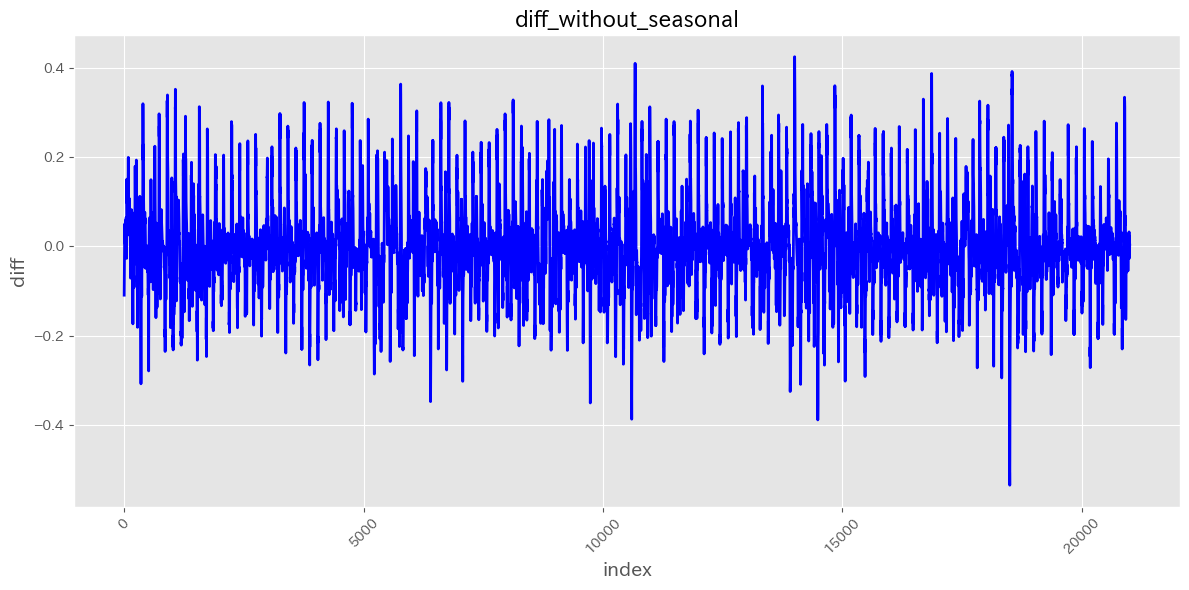

In [ ]:
#24時間の季節性を抜く
diff_without_day_seasonal = train_log[24:] - train_log[:-24]
print(diff_without_day_seasonal[:5])

#plt.figure(figsize=(12, 6))
plt.plot(range(len(diff_without_day_seasonal)), diff_without_day_seasonal, color='b', linestyle='-', linewidth=2, markersize=8)
plt.title('diff_without_seasonal', fontsize=16)
plt.xlabel('index', fontsize=14)
plt.ylabel('diff', fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()


# グラフを表示
plt.show()

<Figure size 1200x600 with 0 Axes>

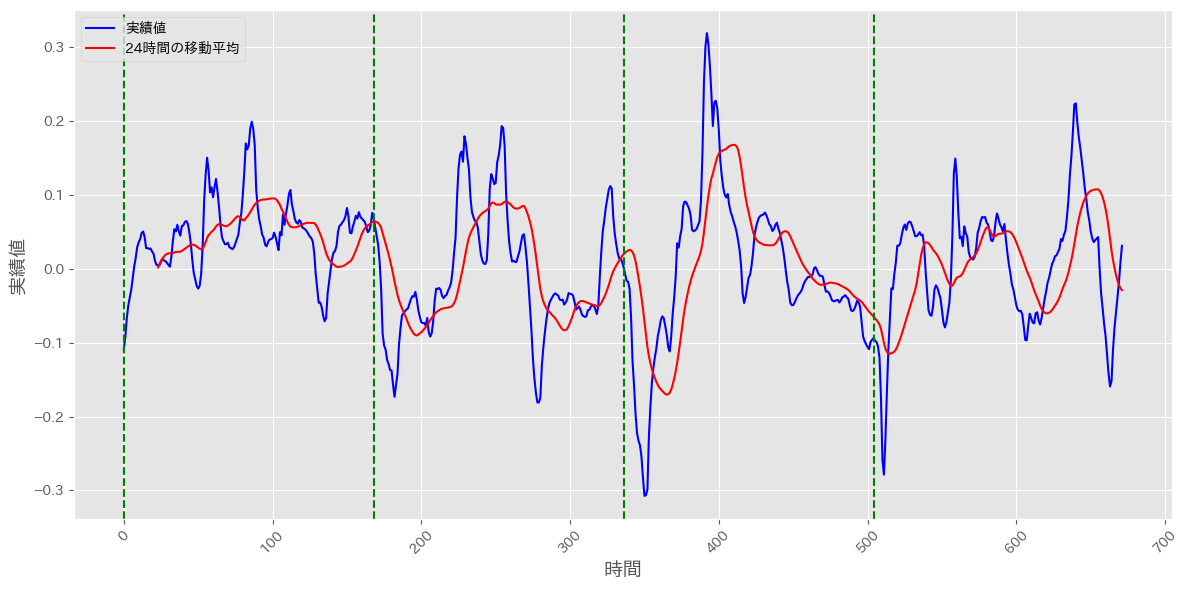

In [ ]:
# グラフの描画
plt.figure(figsize=(12, 6))
fig, ax = plt.subplots()

# 移動平均の計算
diff_without_day_seasonal_df = pd.DataFrame(diff_without_day_seasonal)
rolling_average = diff_without_day_seasonal_df.rolling(window=24).mean()

# 折れ線グラフ
plt.plot(diff_without_day_seasonal[:24*28], label='実績値', color='blue')

# 移動平均のグラフ
plt.plot(rolling_average[:24*28], label='24時間の移動平均', color='red')

# 24時間毎に線を描画
for x in np.arange(0, len(train[:24*28]), 168):
    plt.axvline(x=x, color='green', linestyle='--')

# グラフにタイトルと軸ラベルを追加
plt.xlabel('時間', fontsize=14)
plt.ylabel('実績値', fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
ax.legend(loc='upper left')
plt.show()


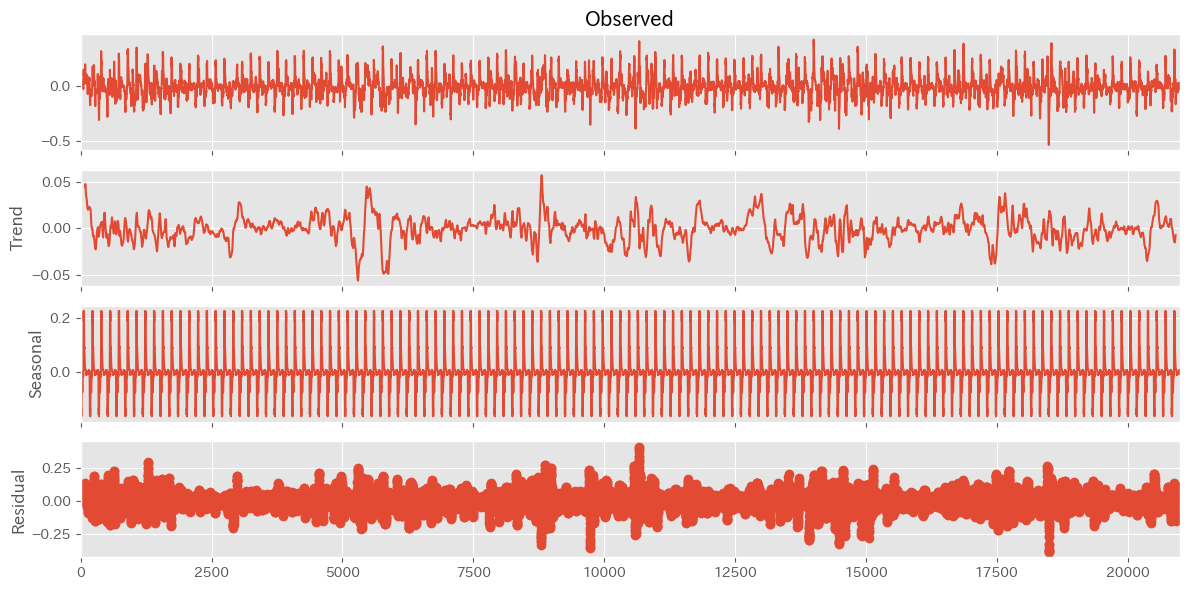

In [ ]:
# 成分分解を実行
result = seasonal_decompose(diff_without_day_seasonal, model='additive', period=168)

# 結果のプロット
result.plot()
plt.show()

/usr/local/lib/python3.10/dist-packages/pmdarima/utils/visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


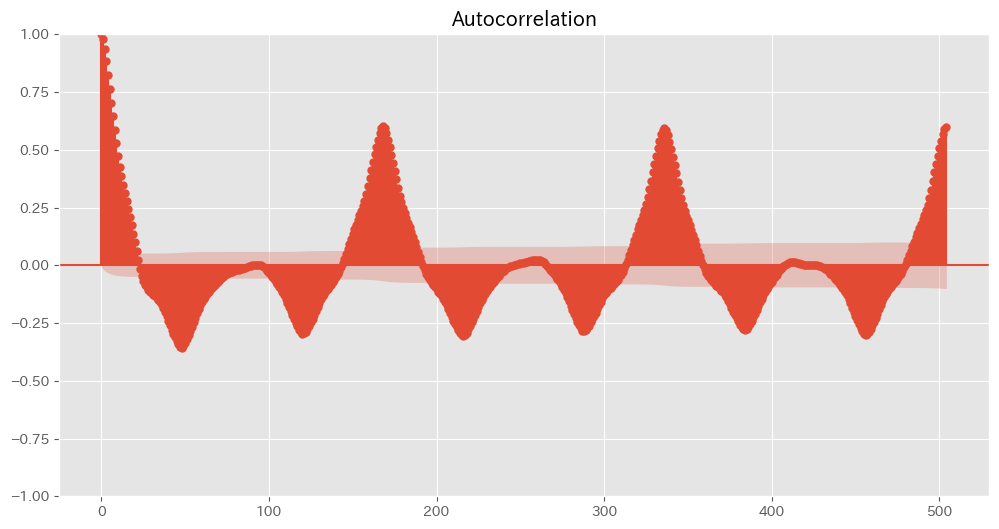

In [ ]:
# トレンドを抜いた後のコレログラム（自己相関と偏自己相関）
plt.rc("figure", figsize = (12, 6))
utils.plot_acf(diff_without_day_seasonal, alpha=.05, lags=24*21)
#utils.plot_pacf(diff_without_day_seasonal, alpha=.05, lags=336*2)

In [ ]:
df['ds'] = pd.to_datetime(df['ds'])
df.set_index('ds', inplace=True)

# '実績(万kW)'を日ごとにリサンプリングし、各日の合計値を計算します。
df_daily = df['実績(万kW)'].resample('D').sum()


In [ ]:
print(df_daily[31])


93195


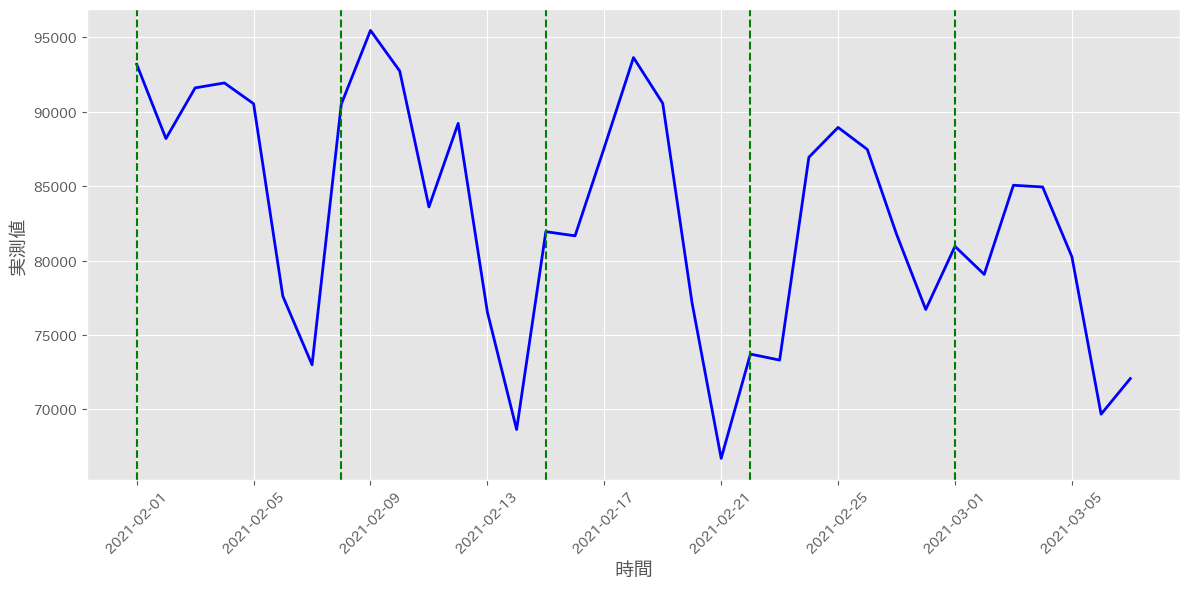

In [ ]:

plt.figure(figsize=(12, 6))

# 日付データの作成（2021/02/01からの５週間分）
dates = pd.date_range(start='2021-02-01', periods=35)

plt.plot(dates, df_daily[31:66], color='b', linestyle='-', linewidth=2, markersize=8)

# 週毎に線を描画
for x in np.arange(0, len(dates), 7):
    plt.axvline(x=dates[x], color='green', linestyle='--')

plt.xlabel('時間', fontsize=14)
plt.ylabel('実測値', fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()


[0.17745924 0.14906164 0.11112349 0.08191191 0.04736139]


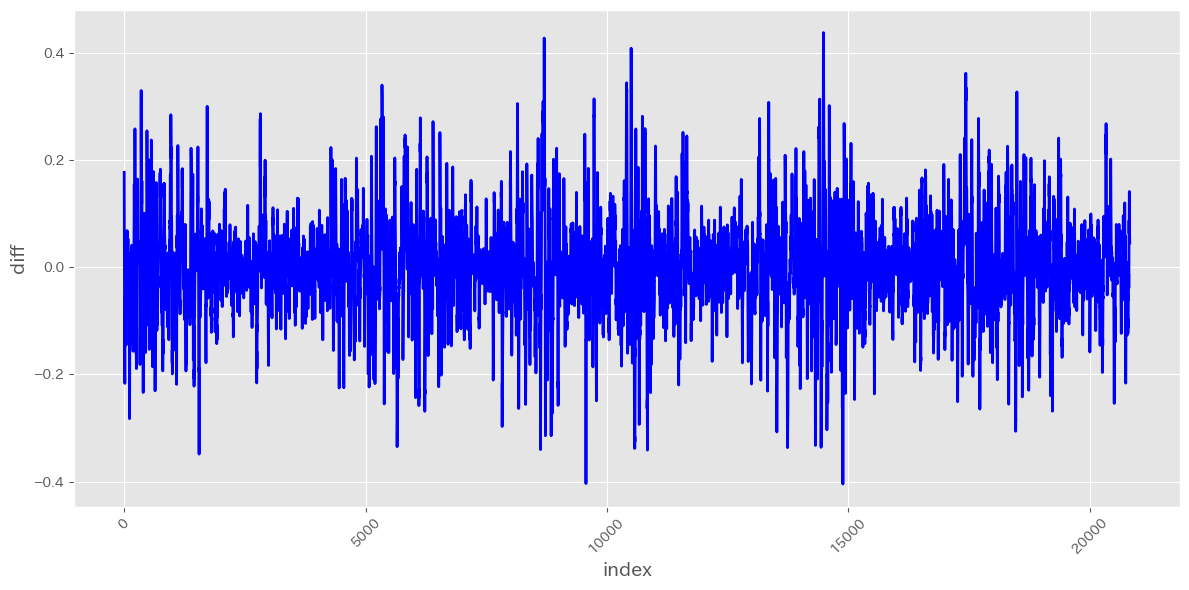

In [ ]:
#週毎の季節性を抜く
diff_without_week_seasonal = diff_without_day_seasonal[168:] - diff_without_day_seasonal[:-168]
print(diff_without_week_seasonal[:5])

#plt.figure(figsize=(12, 6))
plt.plot(range(len(diff_without_week_seasonal)), diff_without_week_seasonal, color='b', linestyle='-', linewidth=2, markersize=8)
plt.xlabel('index', fontsize=14)
plt.ylabel('diff', fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()


# グラフを表示
plt.show()

<Figure size 1200x600 with 0 Axes>

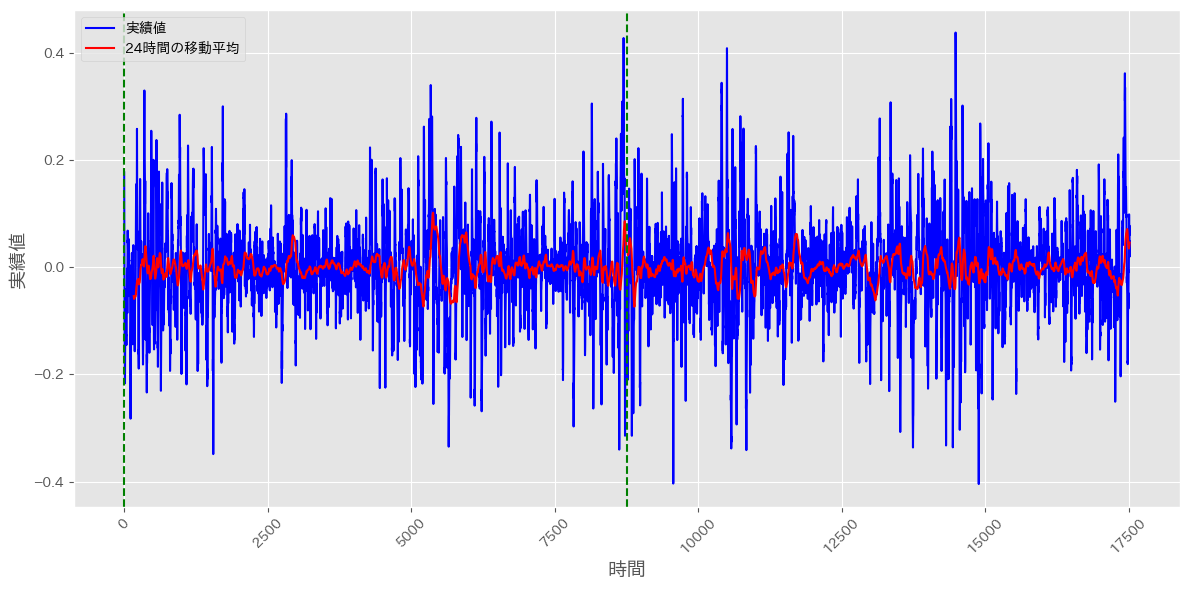

In [ ]:
# グラフの描画
plt.figure(figsize=(12, 6))
fig, ax = plt.subplots()

# 移動平均の計算
diff_without_week_seasonal_df = pd.DataFrame(diff_without_week_seasonal)
rolling_average = diff_without_week_seasonal_df.rolling(window=24*7).mean()

# 折れ線グラフ
plt.plot(diff_without_week_seasonal[:24*365*2], label='実績値', color='blue')

# 移動平均のグラフ
plt.plot(rolling_average[:24*365*2], label='24時間の移動平均', color='red')

# 24時間毎に線を描画
for x in np.arange(0, len(diff_without_week_seasonal_df[:24*365*2]), 24*365):
    plt.axvline(x=x, color='green', linestyle='--')

# グラフにタイトルと軸ラベルを追加
plt.xlabel('時間', fontsize=14)
plt.ylabel('実績値', fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
ax.legend(loc='upper left')
plt.show()


/usr/local/lib/python3.10/dist-packages/pmdarima/utils/visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


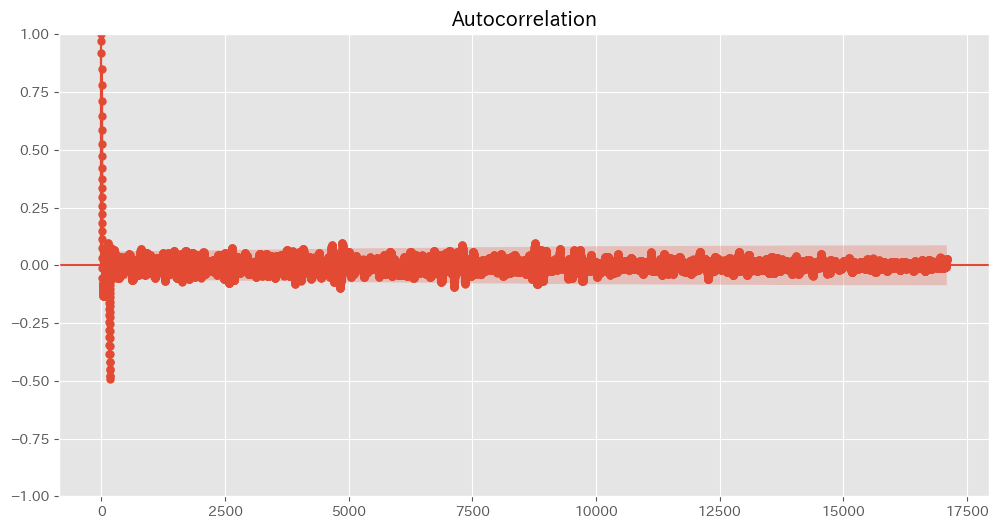

In [ ]:
utils.plot_acf(diff_without_week_seasonal, alpha=.05, lags=356*24*2)
#utils.plot_pacf(diff_without_week_seasonal, alpha=.05, lags=720)

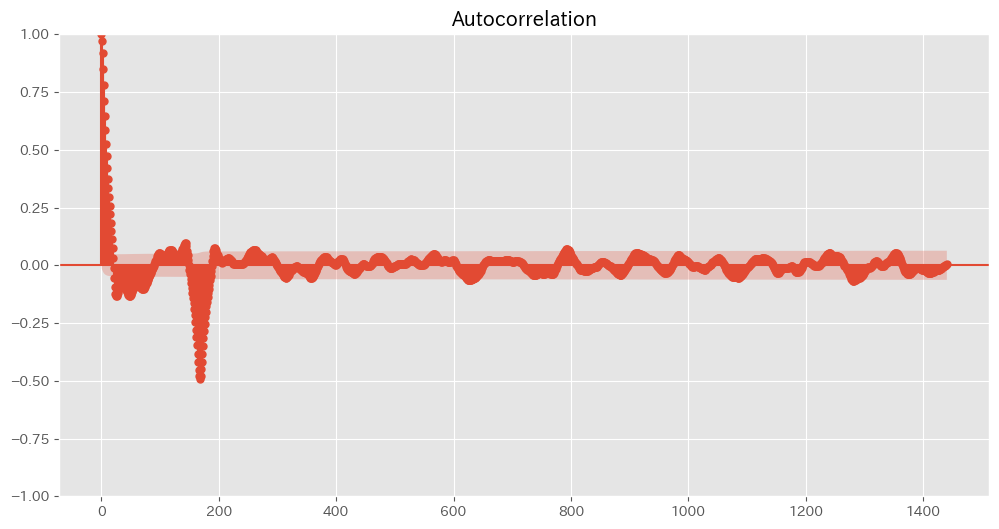

In [ ]:
utils.plot_acf(diff_without_week_seasonal, alpha=.05, lags=24*60)

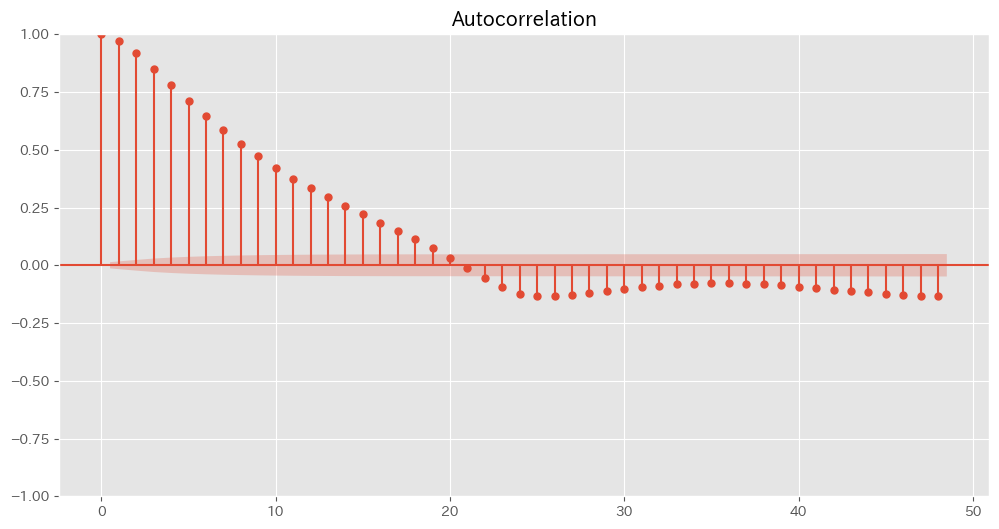

In [ ]:
utils.plot_acf(diff_without_week_seasonal, alpha=.05, lags=24*2)

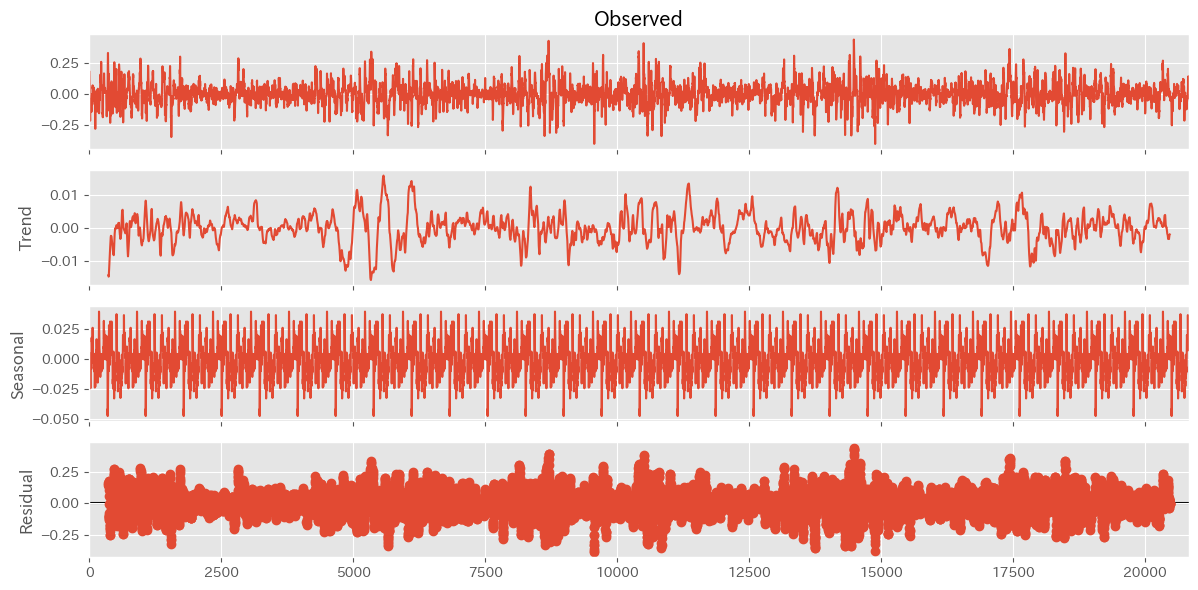

In [ ]:
# 成分分解を実行
result = seasonal_decompose(diff_without_week_seasonal, model='additive', period=30*24)

# 結果のプロット
result.plot()
plt.show()

In [ ]:
diff_without_week_seasonal_diff = np.diff(diff_without_week_seasonal, n=1)

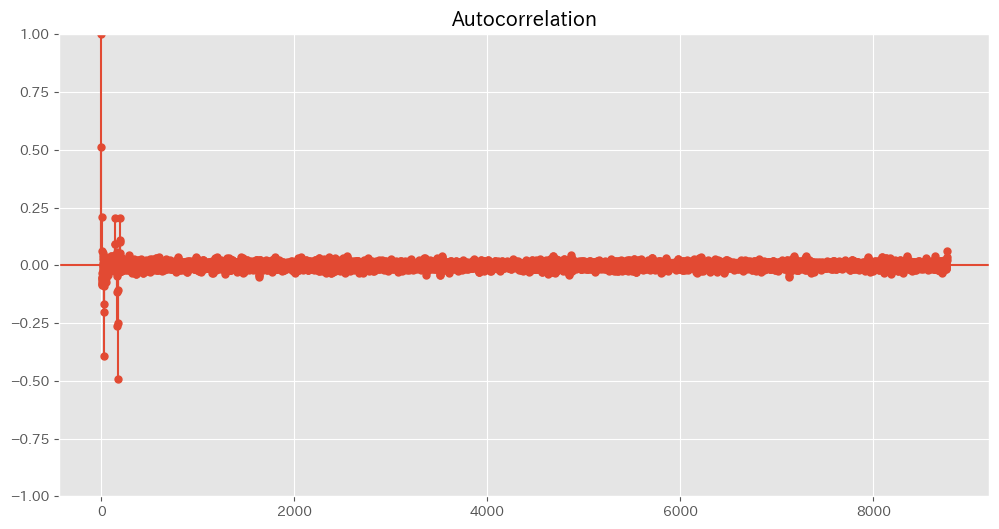

In [ ]:
utils.plot_acf(diff_without_week_seasonal_diff, alpha=.05, lags=24*365)

In [ ]:
# モデルの設定
# arima_model = pm.auto_arima(diff_without_week_seasonal,
#                              seasonal=False,
#                              trace=True,
#                              n_jobs=-1,
#                              maxiter=10)


In [ ]:
# # # モデルの設定
# arima_model = pm.auto_arima(diff_without_week_seasonal,
#                              seasonal=False,
#                              trace=True)


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# モデルの構築
model = ARIMA(diff_without_week_seasonal, order=(3, 0, 2))

# モデルの学習
model_fit = model.fit()

# 予測の開始と終了のインデックスを指定
start_index = 0
end_index = len(test) - 1

# 予測の実行
predictions = model_fit.predict(start=start_index, end=end_index)

# 予測結果の出力
print(predictions[:5])


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[-0.00051298  0.17264668  0.12773151  0.08668062  0.06336553]


In [ ]:
#テストデータ変換（logにする）
test_log = np.log(test)

#24時間の季節性を抜く
diff_without_day_seasonal_test = test_log[24:] - test_log[:-24]
#週毎の季節性を抜く
diff_without_week_seasonal_test = diff_without_day_seasonal_test[168:] - diff_without_day_seasonal_test[:-168]


In [ ]:
predictions = predictions[192:]
print(len(test_log))
print(len(diff_without_day_seasonal_test))
print(len(diff_without_week_seasonal_test))
print(len(predictions))


5256
5232
5064
5064


In [ ]:
# 週毎の季節性を加える
predictions_with_week_seasonal_test = predictions + diff_without_day_seasonal_test[:-168]

# 24時間の季節性を加える
test_re = predictions_with_week_seasonal_test + test_log[:-192]



In [ ]:
# # 予測結果を元のスケールに戻します
test_re = np.exp(test_re)
test = test[:-192]





In [ ]:
# テストデータと予測結果の比較
mape = mean_absolute_percentage_error(test, test_re)
print(f"平均絶対パーセント誤差 (MAPE): {mape}")



平均絶対パーセント誤差 (MAPE): 0.08342412953367397


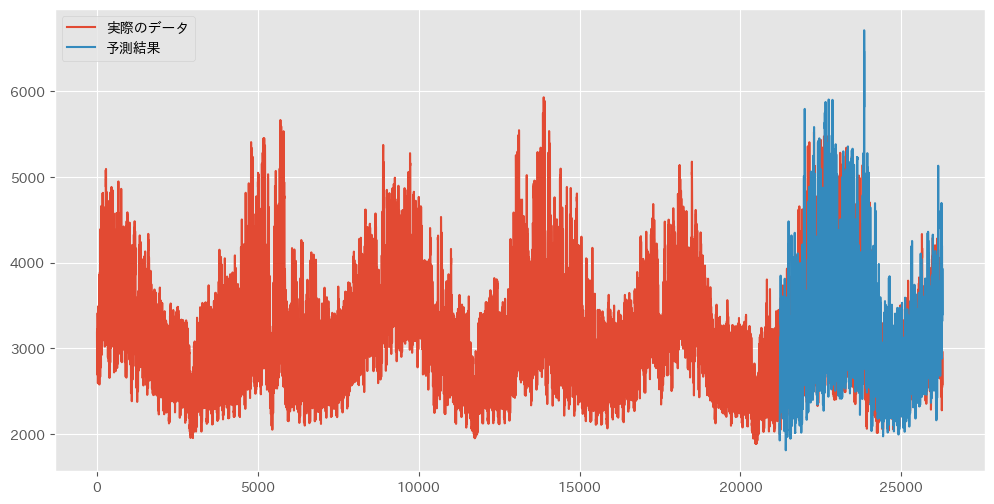

In [ ]:
# 実際のデータと予測結果の可視化
plt.figure(figsize=(12, 6))
plt.plot(data, label='実際のデータ')
plt.plot(range(train_size+192, len(data)), test_re, label='予測結果')
ax.legend(loc='upper right')
plt.legend()
plt.show()

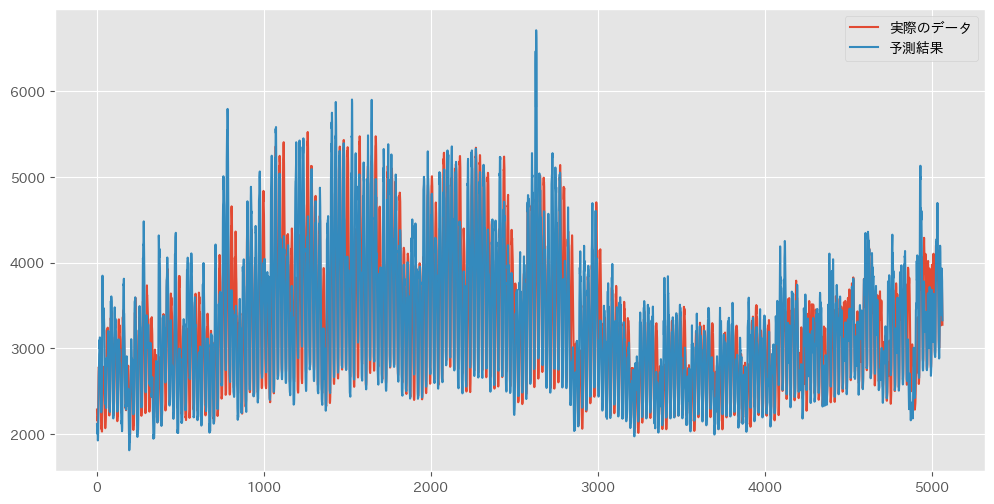

In [ ]:
# 実際のデータと予測結果の可視化
plt.figure(figsize=(12, 6))
plt.plot(test, label='実際のデータ')
plt.plot(range(0, len(test_re)), test_re, label='予測結果')
plt.legend()
plt.show()

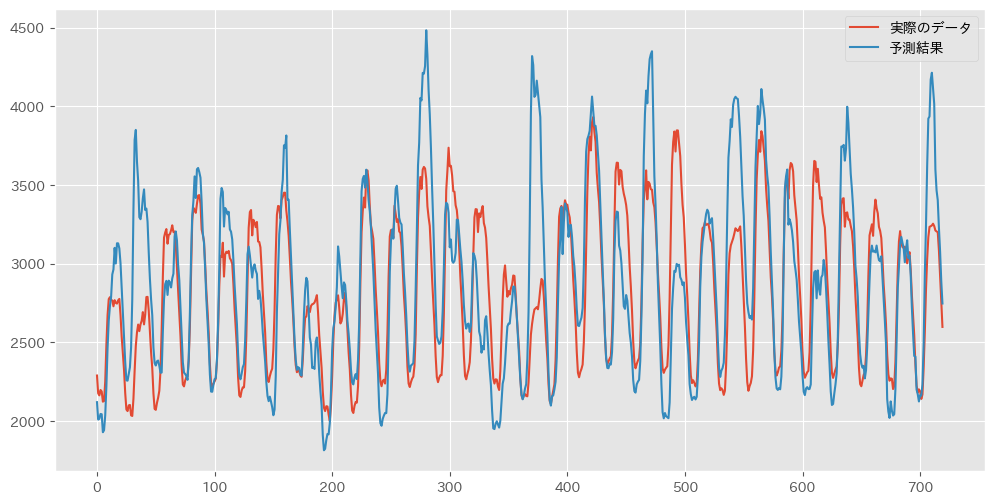

In [ ]:
# 実際のデータと予測結果の可視化
plt.figure(figsize=(12, 6))
plt.plot(test[:24*30], label='実際のデータ')
plt.plot(range(0, len(test_re[:24*30])), test_re[:24*30], label='予測結果')
plt.legend()
plt.show()